In [105]:
import matplotlib.pyplot as plt
import numpy as np
import SimpleITK as sitk

from pathlib import Path
from readii.io.loaders import loadImageDatasetConfig


import sys; sys.path.append("..")
from process_crop import find_centroid, crop_fmcib_input

In [2]:
import os
os.getcwd()

'/home/bioinf/bhklab/radiomics/readii-fmcib/code/notebooks'

In [5]:
config = loadImageDatasetConfig("RADCURE", Path("../../config"))

DATASET_NAME = config["dataset_name"]

ROI_PATTERN = config["roi_pattern"]
ROI_NAME = list(ROI_PATTERN.keys())[0]

MODALITIES = config['modalities']

NEG_CONTROL_REGIONS = config["negative_control_regions"]
NEG_CONTROL_TYPES = config["negative_control_types"]

In [6]:
patient_id = "RADCURE-0300"

In [36]:
def loadNifti(img_path) -> np.array:
    sitk_img = sitk.ReadImage(img_path)
    return sitk.GetArrayFromImage(sitk_img)

def loadCroppedCT(patient_id, crop_method, image_type) -> np.array:
    img_path = Path(f"../../procdata/RADCURE/images/cropped_images/cropped_{crop_method}/{image_type}/{patient_id}.nii.gz")
    return loadNifti(img_path)

def loadOriginalCT(patient_id) -> np.array:
    pat_dir = list(Path("../../procdata/RADCURE/images/converted_niftis/").glob(f"*{patient_id}"))[0]
    img_path = pat_dir / "CT/CT.nii.gz"
    return loadNifti(img_path)

def loadOriginalMask(patient_id, roi_name) -> sitk.Image:
    pat_dir = list(Path("../../procdata/RADCURE/images/converted_niftis/").glob(f"*{patient_id}"))[0]
    img_path = pat_dir / f"RTSTRUCT_CT/{roi_name}.nii.gz"
    return sitk.ReadImage(img_path)


In [73]:
def plotSliceOnAxis(axis, img_slice, vmin, vmax, cmap=plt.cm.Greys_r):
    axis.imshow(img_slice, cmap=cmap, vmin=vmin, vmax=vmax)
    axis.set_axis_off()
    return axis

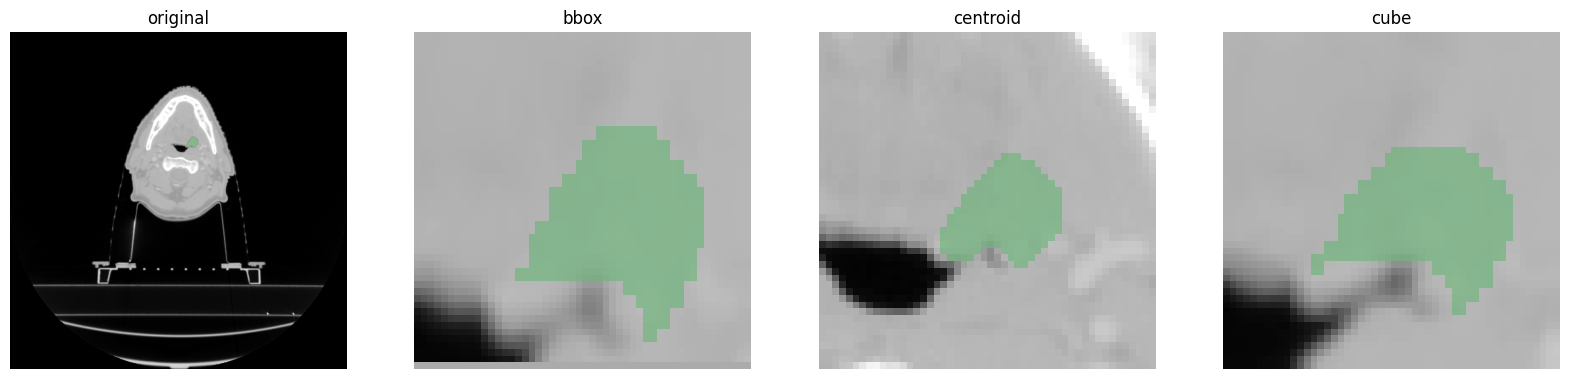

In [106]:
image_type = "original"
figure, axis = plt.subplots(1,4)
figure.set_figwidth(20)
cmap=plt.cm.Greys_r
# range values taken from cube crop image
disp_min = -1000
disp_max = 755

original_mask = loadOriginalMask(patient_id, ROI_NAME)

crop_types = ["original", "bbox", "centroid", "cube"]


for idx, crop_type in enumerate(crop_types):

    match crop_type:
        case "original":
            image = loadOriginalCT(patient_id)
            slice_idx = int(find_centroid(original_mask)[2])

            arr_mask = sitk.GetArrayFromImage(original_mask)
            bin_mask = np.ma.masked_where(arr_mask==0, arr_mask) 
            axis[idx].imshow(bin_mask[slice_idx], cmap=plt.cm.Greens, vmin=disp_min, vmax=disp_max, alpha=0.5)

        case "bbox" | "centroid" | "cube":
            image = loadCroppedCT(patient_id, crop_type, image_type)
            slice_idx = image.shape[0] // 2

            cropped_mask = crop_fmcib_input(image = original_mask, mask = original_mask, crop_method = crop_type, input_size = image.shape)
            arr_mask = sitk.GetArrayFromImage(cropped_mask)
    
    plotSliceOnAxis(axis[idx], img_slice=image[slice_idx,:,:], vmin=disp_min, vmax=disp_max)
    # Plot segmentation mask as overlay
    bin_mask = np.ma.masked_where(arr_mask==0, arr_mask) 
    axis[idx].imshow(bin_mask[slice_idx], cmap=plt.cm.Greens, vmin=disp_min, vmax=disp_max, alpha=0.5)
    axis[idx].set_title(crop_type)



In [104]:
type(image.shape)

tuple